# Retrieval evaluation

In [8]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import cmocean
import matplotlib.pyplot as plt
from matplotlib import style
from ccic.plotting import set_style
from pathlib import Path

set_style()
DATA_PATH = Path("/home/simonpf/copper/ccic")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Example scenes

In [9]:
from torch.utils.data import DataLoader
from ccic.data.training_data import CCICDataset

input_data = CCICDataset(
    DATA_PATH / "dataset/test_data/cpcir/2010_01/",
    inference=True,
)

In [11]:
results = xr.load_dataset(DATA_PATH / "results/test_data/results_cpcir_2010_01.nc")

In [12]:
input_files = input_data.files
def get_input(scene):
    return xr.load_dataset(input_files[scene])[{
        "latitude": slice(64, -64),
        "longitude": slice(64, -64)
    }]

In [13]:
scenes = np.unique(results.scene.data)

In [14]:
scene_ind = np.random.choice(scenes)

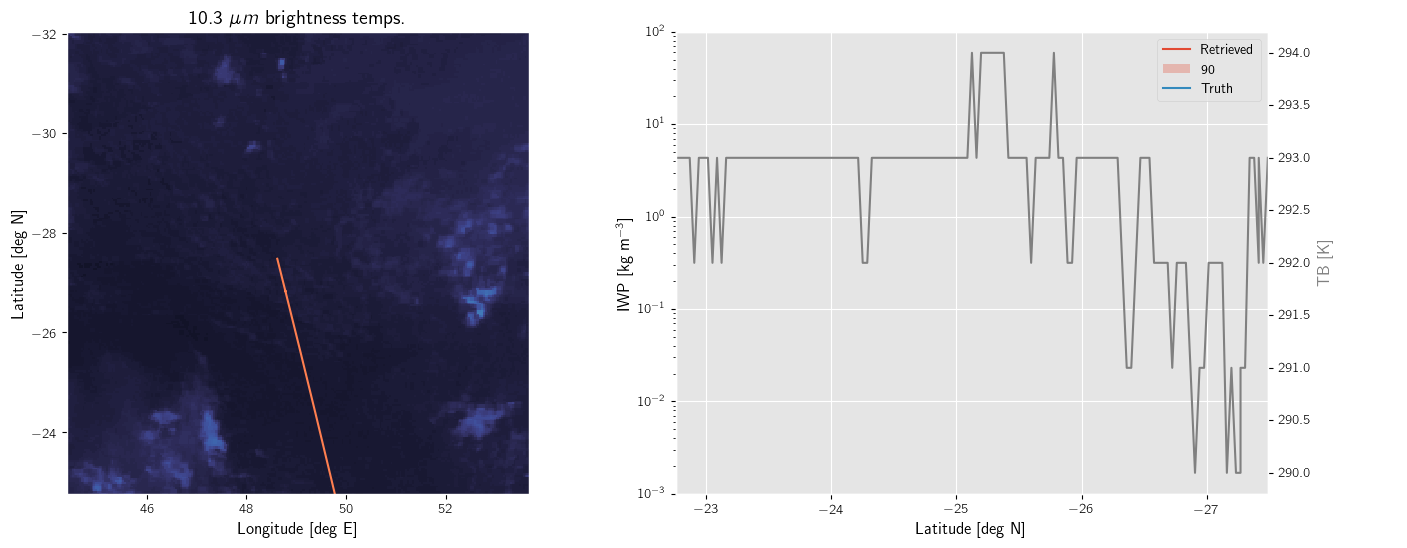

In [15]:
from matplotlib.gridspec import GridSpec
f = plt.figure(figsize=(18, 6))
gs = GridSpec(2, 3, width_ratios=[1.0, 1.0, 0.08])

ax = f.add_subplot(gs[:, 0])
data = get_input(scene_ind)
tbs = data.ir_win.data
lons = data.longitude.data
lats = data.latitude.data
m = ax.pcolormesh(lons, lats, tbs, vmin=220, vmax=300, rasterized=True)

lons_cs = data.longitude_cloudsat.data
lats_cs = data.latitude_cloudsat.data
ax.plot(lons_cs, lats_cs, c="coral")
ax.set_xlim(lons[0], lons[-1])
ax.set_ylim(lats[0], lats[-1])
ax.set_aspect(1.0)
ax.set_xlabel("Longitude [deg E]")
ax.set_ylabel("Latitude [deg N]")
ax.set_title("10.3 $\mu m$ brightness temps.")

scene = results[{"samples": results.scene.data == scene_ind}]

ax = f.add_subplot(gs[:, 1])
tiwp = scene.tiwp_mean.data
tiwp_true = scene.tiwp_fpavg_true.data
tiwp_log_std_dev = scene.tiwp_log_std_dev.data
tiwp_fpavg_log_std_dev = scene.tiwp_fpavg_log_std_dev
tiwp_min = 10 ** (np.log10(tiwp) - 1.0 * tiwp_log_std_dev)
tiwp_max = 10 ** (np.log10(tiwp) + 1.0 * tiwp_log_std_dev)
tiwp_fpavg_min = 10 ** (np.log10(tiwp) - 1.0 * tiwp_fpavg_log_std_dev)
tiwp_fpavg_max = 10 ** (np.log10(tiwp) + 1.0 * tiwp_fpavg_log_std_dev)

lats = scene.latitude.data
ax.plot(lats, tiwp, c="C0", label="Retrieved")
ax.fill_between(lats, tiwp_min, tiwp_max, facecolor="C0", alpha=0.3, label="90% CI")
ax.plot(lats, tiwp_true, c="C1", label="Truth")
ax.set_yscale("log")
ax.set_ylim([1e-3, 1e2])
ax.set_xlim(lats[0], lats[-1])
ax.set_xlabel("Latitude [deg N]")
ax.set_ylabel("IWP [kg m$^{-3}$]")
ax.legend()

ax = ax.twinx()
ax.plot(lats, scene.tbs.data, c="grey")
ax.set_ylabel("TB [K]", color="grey")
ax.grid(False)

ax = f.add_subplot(gs[:, -1])
ax.set_axis_off()

plt.savefig("iwp.png", bbox_inches="tight", dpi=200)

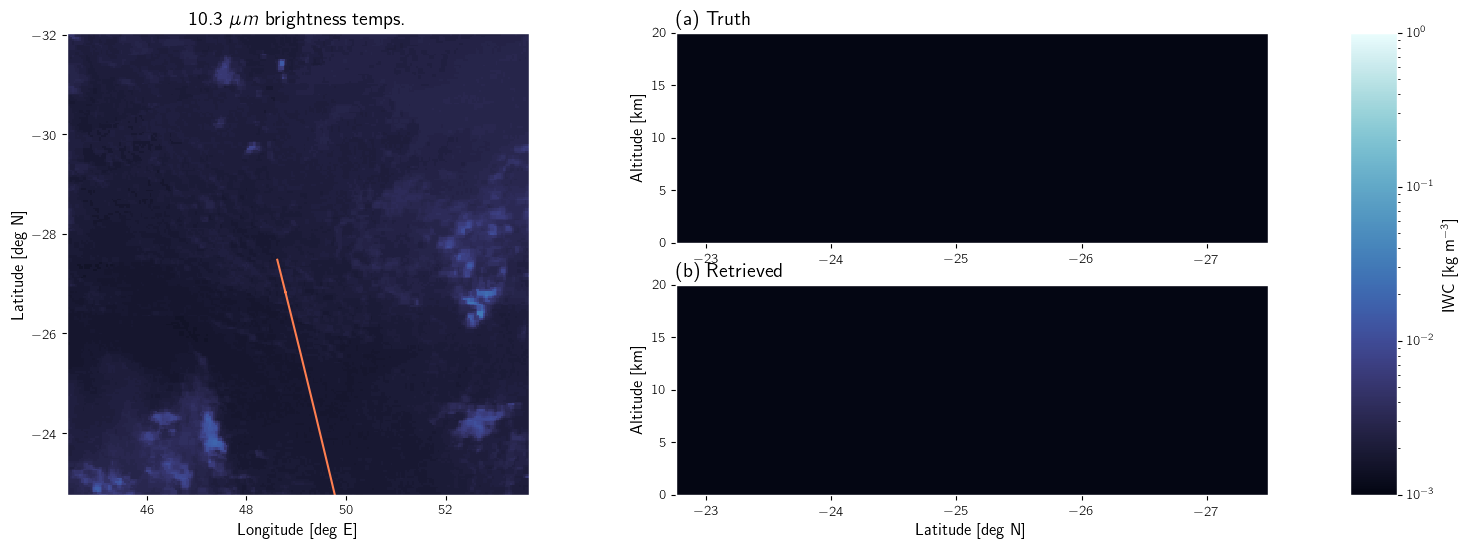

In [16]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
f = plt.figure(figsize=(18, 6))
gs = GridSpec(2, 3, width_ratios=[1.0, 1.0, 0.08])

ax = f.add_subplot(gs[:, 0])
lons = data.longitude.data
lats = data.latitude.data
m = ax.pcolormesh(lons, lats, tbs, vmin=220, vmax=300, rasterized=True)

lons_cs = data.longitude_cloudsat.data
lats_cs = data.latitude_cloudsat.data
ax.plot(lons_cs, lats_cs, c="coral")
ax.set_xlim(lons[0], lons[-1])
ax.set_ylim(lats[0], lats[-1])
ax.set_aspect(1.0)
ax.set_xlabel("Longitude [deg E]")
ax.set_ylabel("Latitude [deg N]")
ax.set_title("10.3 $\mu m$ brightness temps.")

ax = f.add_subplot(gs[0, 1])
z = scene.levels / 1e3
lats = scene.latitude.data
iwc_true = scene.tiwc_true.data
ax.pcolormesh(lats, z, iwc_true.T, norm=LogNorm(1e-3, 1e-0), cmap="cmo.ice", rasterized=True)
ax.set_title("(a) Truth", loc="left")
ax.set_ylabel("Altitude [km]")
ax.set_xlim(lats[0], lats[-1])

ax = f.add_subplot(gs[1, 1])
z = scene.levels / 1e3
iwc = scene.tiwc_mean.data
m = ax.pcolormesh(lats, z, iwc.T, norm=LogNorm(1e-3, 1e-0), cmap="cmo.ice", rasterized=True)
ax.set_title("(b) Retrieved", loc="left")
ax.set_xlabel("Latitude [deg N]")
ax.set_ylabel("Altitude [km]")
ax.set_xlim(lats[0], lats[-1])

ax = f.add_subplot(gs[:, -1])
plt.colorbar(m, cax=ax, label="IWC [kg m$^{-3}$]")
f.savefig("iwc.png", dpi=200, bbox_inches="tight")

In [17]:
cc_true = scene.cloud_class_true.data
cc_prob = scene.cloud_class_prob.data

def get_most_likely_class(probs):
    no_cloud = probs[..., 0] > 0.632
    cloud_class = np.argmax(probs[..., 1:], axis=-1)
    result = np.zeros(no_cloud.shape, dtype=int)
    result[no_cloud] = 0
    result[~no_cloud] = cloud_class[~no_cloud] + 1
    return result

cc = get_most_likely_class(cc_prob)

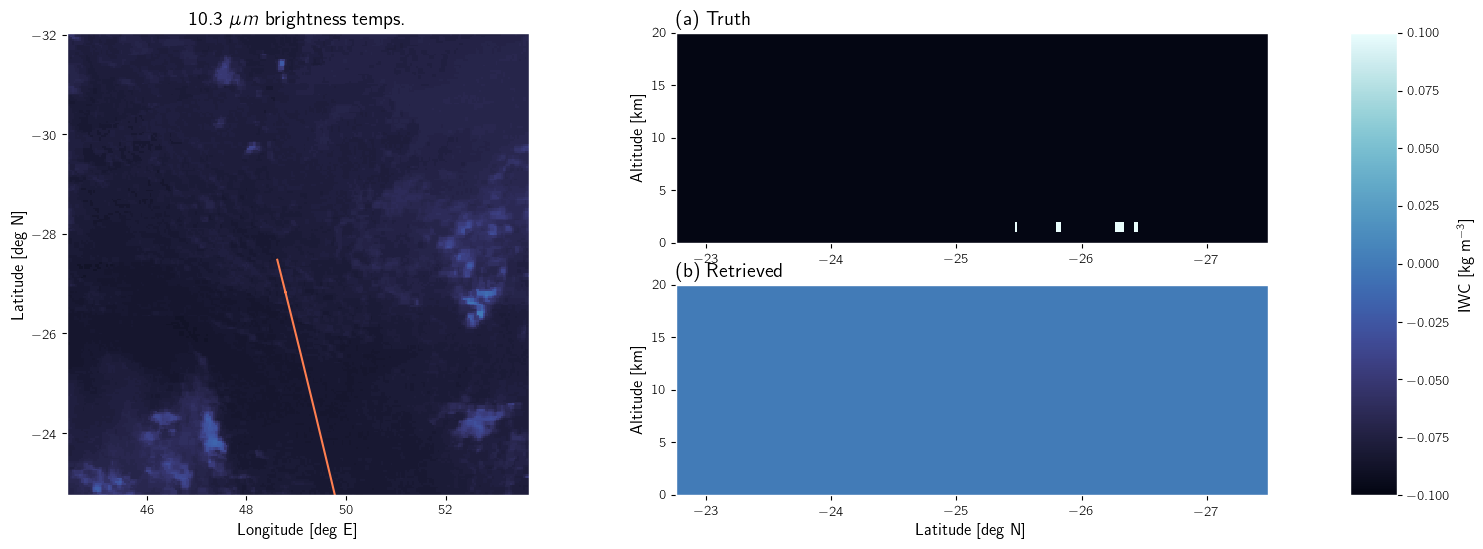

In [18]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
f = plt.figure(figsize=(18, 6))
gs = GridSpec(2, 3, width_ratios=[1.0, 1.0, 0.08])

ax = f.add_subplot(gs[:, 0])
lons = data.longitude.data
lats = data.latitude.data
m = ax.pcolormesh(lons, lats, tbs, vmin=220, vmax=300, rasterized=True)

lons_cs = data.longitude_cloudsat.data
lats_cs = data.latitude_cloudsat.data
ax.plot(lons_cs, lats_cs, c="coral")
ax.set_xlim(lons[0], lons[-1])
ax.set_ylim(lats[0], lats[-1])
ax.set_aspect(1.0)
ax.set_xlabel("Longitude [deg E]")
ax.set_ylabel("Latitude [deg N]")
ax.set_title("10.3 $\mu m$ brightness temps.")

ax = f.add_subplot(gs[0, 1])
z = scene.levels / 1e3
lats = scene.latitude.data
ax.pcolormesh(lats, z, cc_true.T, cmap="cmo.ice", rasterized=True)
ax.set_title("(a) Truth", loc="left")
ax.set_ylabel("Altitude [km]")
ax.set_xlim(lats[0], lats[-1])

ax = f.add_subplot(gs[1, 1])
z = scene.levels / 1e3
#m = ax.pcolormesh(lats, z, cc_prob[..., 0].T, cmap="cmo.ice")
m = ax.pcolormesh(lats, z, cc.T, cmap="cmo.ice", rasterized=True)
ax.set_title("(b) Retrieved", loc="left")
ax.set_xlabel("Latitude [deg N]")
ax.set_ylabel("Altitude [km]")
ax.set_xlim(lats[0], lats[-1])

ax = f.add_subplot(gs[:, -1])
plt.colorbar(m, cax=ax, label="IWC [kg m$^{-3}$]")
f.savefig("iwc.png", dpi=200, bbox_inches="tight")

# Retrieval accuracy

In [20]:
def get_column_class(cloud_classes):
    """
    Determine class of column from CCIC cloud class probabilities.
    
    Args:
         cloud_classes: Cloud class probabilities as predicted by CCIC.
         
    Return:
         The corresponding cloud class indices
    """
    cc = np.zeros(cloud_classes.shape[:-1])
    strat = np.any(cloud_classes > 0, -1)
    cc[strat] = 1
    conv = np.any(cloud_classes > 5, -1)
    cc[conv] = 2
    invalid = np.all(cloud_classes > 8, -1)
    cc[invalid] = -1.0
    return cc

In [23]:
from pathlib import Path
result_files_cpcir = sorted(list((DATA_PATH / "results/test_data/").glob("results_cpcir_*.nc")))
results_cpcir = []
for result_file in np.random.permutation(result_files_cpcir)[:6]:
    
    with xr.open_dataset(result_file) as data:
        data = data.drop_vars(["encodings"])
        cloud_class = data.cloud_class_true.data
        cloud_cts = np.zeros((data.samples.size, 9))
        for i in range(8):
            cloud_cts[:, i] += (cloud_class == i).sum(-1)
        cloud_class = get_most_likely_class(data.cloud_class_prob.data)
        data["cloud_mask"] = data.cloud_class_prob[..., 0] > 0.5
        data["cloud_class"] = (("samples", "levels"), cloud_class) 
        
        cc = get_column_class(data.cloud_class_true.data)
        data["column_class"] = (("samples",), cc)
        
        results_cpcir.append(data)
        
results_cpcir = xr.concat(results_cpcir, "samples")

In [24]:
from pathlib import Path
result_files_gridsat = sorted(list((DATA_PATH / "results/test_data/").glob("results_gridsat*.nc")))
results_gridsat = []
for result_file in np.random.permutation(result_files_gridsat):
    
    with xr.open_dataset(result_file) as data:
        data = data.drop_vars(["encodings"])
        cloud_class = data.cloud_class_true.data
        cloud_cts = np.zeros((data.samples.size, 9))
        for i in range(8):
            cloud_cts[:, i] += (cloud_class == i).sum(-1)
        cloud_class = get_most_likely_class(data.cloud_class_prob.data)
        data["cloud_mask"] = data.cloud_class_prob[..., 0] > 0.5
        data["cloud_class"] = (("samples", "levels"), cloud_class) 
        results_gridsat.append(data)
        
        cc = get_column_class(data.cloud_class_true.data)
        data["column_class"] = (("samples",), cc)
        
results_gridsat = xr.concat(results_gridsat, "samples")

## TIWP Retrieval accuracy

### Scatter plots

In [25]:
from scipy.stats import binned_statistic
bins = np.logspace(-3, 2, 201)
y_cpc = np.histogram2d(results_cpcir.tiwp_fpavg_true.data, results_cpcir.tiwp_fpavg_mean.data, bins=bins, density=True)[0]
y_cpc /= np.trapz(np.diff(bins) * y_cpc, axis=-1)[..., None]
cond_mean_cpc = binned_statistic(
    results_cpcir.tiwp_fpavg_true.data,
    results_cpcir.tiwp_fpavg_mean.data,
    lambda x: x.mean() if x.size > 1e2 else np.nan,
    bins=bins)[0]
corr_cpc = np.corrcoef(
    results_cpcir.tiwp_fpavg_true.data,
    results_cpcir.tiwp_fpavg_mean.data
)[0, 1]
bias_cpc = np.mean(results_cpcir.tiwp_fpavg_mean.data - results_cpcir.tiwp_fpavg_true.data) / np.mean(results_cpcir.tiwp_fpavg_mean.data)

y_gs = np.histogram2d(results_gridsat.tiwp_fpavg_true.data, results_gridsat.tiwp_fpavg_mean.data, bins=bins, density=True)[0]
y_gs /= np.trapz(np.diff(bins) * y_gs, axis=-1)[..., None]
cond_mean_gs = binned_statistic(
    results_gridsat.tiwp_fpavg_true.data,
    results_gridsat.tiwp_fpavg_mean.data,
    lambda x: x.mean() if x.size > 1e2 else np.nan,
    bins=bins)[0]
corr_gs = np.corrcoef(
    results_gridsat.tiwp_fpavg_true.data,
    results_gridsat.tiwp_fpavg_mean.data
)[0, 1]
bias_gs = np.mean(results_gridsat.tiwp_fpavg_mean.data - results_gridsat.tiwp_fpavg_true.data) / np.mean(results_gridsat.tiwp_fpavg_mean.data)

/tmp/ipykernel_1036966/666460577.py:4: RuntimeWarning: invalid value encountered in divide
  y_cpc /= np.trapz(np.diff(bins) * y_cpc, axis=-1)[..., None]
/tmp/ipykernel_1036966/666460577.py:17: RuntimeWarning: invalid value encountered in divide
  y_gs /= np.trapz(np.diff(bins) * y_gs, axis=-1)[..., None]


/tmp/ipykernel_858012/732426336.py:16: UserWarning: Log scale: values of z <= 0 have been masked
  m = ax.contourf(x, x, y_cpc.T, norm=norm, levels=levels, extend="both")
/tmp/ipykernel_858012/732426336.py:32: UserWarning: Log scale: values of z <= 0 have been masked
  m = ax.contourf(x, x, y_gs.T, norm=norm, levels=levels, extend="both")


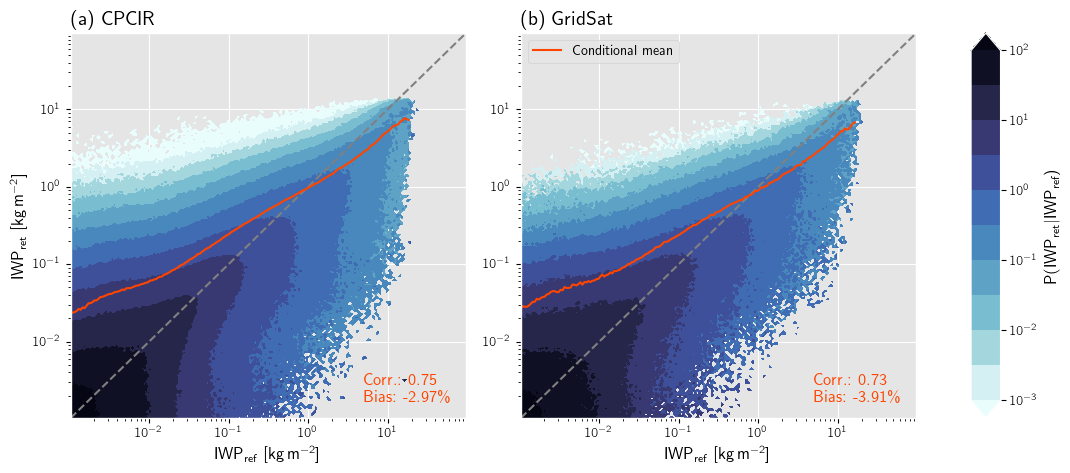

In [15]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm

fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 3, width_ratios=[1.0, 1.0, 0.075])

norm = LogNorm(1e-3, 1e2)
levels = np.logspace(-3, 2, 11)

txtcol = "orangered"
diagcol = "orangered"

ax = fig.add_subplot(gs[0, 0])
ax.set_title("(a) CPCIR", loc="left")
x = 0.5 * (bins[1:] + bins[:-1])
m = ax.contourf(x, x, y_cpc.T, norm=norm, levels=levels, extend="both")
ax.plot(x, x, ls="--", c="grey")
ax.plot(x, cond_mean_cpc, c=diagcol, label="Conditional mean")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$\text{IWP}_\text{ret}$ $[\si{\kilo \gram \per \meter \squared}$]")
ax.set_xlabel(r"$\text{IWP}_\text{ref}$ $[\si{\kilo \gram \per \meter \squared}$]")
ax.text(
    5, 1.5e-3, f"Corr.: {corr_cpc:0.2f} \n Bias: {100 * bias_cpc:0.2f}\%",
    fontsize=12, color=txtcol, ha="left", va="bottom"
)


ax = fig.add_subplot(gs[0, 1])
ax.set_title("(b) GridSat", loc="left")
x = 0.5 * (bins[1:] + bins[:-1])
m = ax.contourf(x, x, y_gs.T, norm=norm, levels=levels, extend="both")
ax.plot(x, x, ls="--", c="grey")
ax.plot(x, cond_mean_gs, c=diagcol, label="Conditional mean")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\text{IWP}_\text{ref}$ $[\si{\kilo \gram \per \meter \squared}$]")
ax.text(5, 1.5e-3, f"Corr.: {corr_gs:0.2f} \n Bias: {100 * bias_gs:0.2f}\%",
        fontsize=12, color=txtcol, ha="left", va="bottom")
ax.legend()

ax = fig.add_subplot(gs[0, 2])
plt.colorbar(m, label=r"$\text{P}(\text{IWP}_\text{ret} | \text{IWP}_\text{ref}$)", cax=ax)
fig.savefig("../figures/scatter_tiwp.png", dpi=200, bbox_inches="tight")

/tmp/ipykernel_858012/732426336.py:16: UserWarning: Log scale: values of z <= 0 have been masked
  m = ax.contourf(x, x, y_cpc.T, norm=norm, levels=levels, extend="both")
/tmp/ipykernel_858012/732426336.py:32: UserWarning: Log scale: values of z <= 0 have been masked
  m = ax.contourf(x, x, y_gs.T, norm=norm, levels=levels, extend="both")


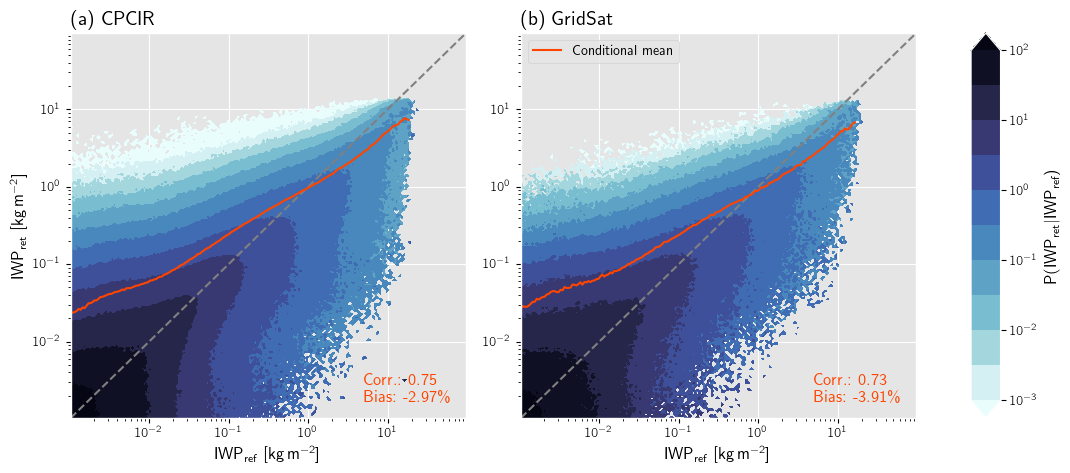

In [16]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm

fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 3, width_ratios=[1.0, 1.0, 0.075])

norm = LogNorm(1e-3, 1e2)
levels = np.logspace(-3, 2, 11)

txtcol = "orangered"
diagcol = "orangered"

ax = fig.add_subplot(gs[0, 0])
ax.set_title("(a) CPCIR", loc="left")
x = 0.5 * (bins[1:] + bins[:-1])
m = ax.contourf(x, x, y_cpc.T, norm=norm, levels=levels, extend="both")
ax.plot(x, x, ls="--", c="grey")
ax.plot(x, cond_mean_cpc, c=diagcol, label="Conditional mean")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$\text{IWP}_\text{ret}$ $[\si{\kilo \gram \per \meter \squared}$]")
ax.set_xlabel(r"$\text{IWP}_\text{ref}$ $[\si{\kilo \gram \per \meter \squared}$]")
ax.text(
    5, 1.5e-3, f"Corr.: {corr_cpc:0.2f} \n Bias: {100 * bias_cpc:0.2f}\%",
    fontsize=12, color=txtcol, ha="left", va="bottom"
)


ax = fig.add_subplot(gs[0, 1])
ax.set_title("(b) GridSat", loc="left")
x = 0.5 * (bins[1:] + bins[:-1])
m = ax.contourf(x, x, y_gs.T, norm=norm, levels=levels, extend="both")
ax.plot(x, x, ls="--", c="grey")
ax.plot(x, cond_mean_gs, c=diagcol, label="Conditional mean")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\text{IWP}_\text{ref}$ $[\si{\kilo \gram \per \meter \squared}$]")
ax.text(5, 1.5e-3, f"Corr.: {corr_gs:0.2f} \n Bias: {100 * bias_gs:0.2f}\%",
        fontsize=12, color=txtcol, ha="left", va="bottom")
ax.legend()

ax = fig.add_subplot(gs[0, 2])
plt.colorbar(m, label=r"$\text{P}(\text{IWP}_\text{ret} | \text{IWP}_\text{ref}$)", cax=ax)
fig.savefig("../figures/scatter_tiwp.png", dpi=200, bbox_inches="tight")

/tmp/ipykernel_858012/732426336.py:16: UserWarning: Log scale: values of z <= 0 have been masked
  m = ax.contourf(x, x, y_cpc.T, norm=norm, levels=levels, extend="both")
/tmp/ipykernel_858012/732426336.py:32: UserWarning: Log scale: values of z <= 0 have been masked
  m = ax.contourf(x, x, y_gs.T, norm=norm, levels=levels, extend="both")


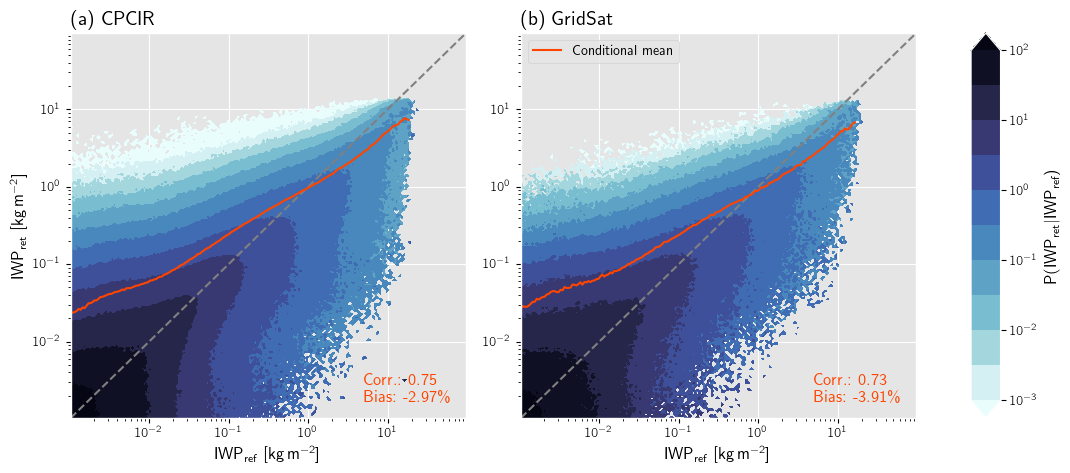

In [17]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm

fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 3, width_ratios=[1.0, 1.0, 0.075])

norm = LogNorm(1e-3, 1e2)
levels = np.logspace(-3, 2, 11)

txtcol = "orangered"
diagcol = "orangered"

ax = fig.add_subplot(gs[0, 0])
ax.set_title("(a) CPCIR", loc="left")
x = 0.5 * (bins[1:] + bins[:-1])
m = ax.contourf(x, x, y_cpc.T, norm=norm, levels=levels, extend="both")
ax.plot(x, x, ls="--", c="grey")
ax.plot(x, cond_mean_cpc, c=diagcol, label="Conditional mean")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$\text{IWP}_\text{ret}$ $[\si{\kilo \gram \per \meter \squared}$]")
ax.set_xlabel(r"$\text{IWP}_\text{ref}$ $[\si{\kilo \gram \per \meter \squared}$]")
ax.text(
    5, 1.5e-3, f"Corr.: {corr_cpc:0.2f} \n Bias: {100 * bias_cpc:0.2f}\%",
    fontsize=12, color=txtcol, ha="left", va="bottom"
)


ax = fig.add_subplot(gs[0, 1])
ax.set_title("(b) GridSat", loc="left")
x = 0.5 * (bins[1:] + bins[:-1])
m = ax.contourf(x, x, y_gs.T, norm=norm, levels=levels, extend="both")
ax.plot(x, x, ls="--", c="grey")
ax.plot(x, cond_mean_gs, c=diagcol, label="Conditional mean")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\text{IWP}_\text{ref}$ $[\si{\kilo \gram \per \meter \squared}$]")
ax.text(5, 1.5e-3, f"Corr.: {corr_gs:0.2f} \n Bias: {100 * bias_gs:0.2f}\%",
        fontsize=12, color=txtcol, ha="left", va="bottom")
ax.legend()

ax = fig.add_subplot(gs[0, 2])
plt.colorbar(m, label=r"$\text{P}(\text{IWP}_\text{ret} | \text{IWP}_\text{ref}$)", cax=ax)
fig.savefig("../figures/scatter_tiwp.png", dpi=200, bbox_inches="tight")

### Zonal distributions

In [19]:
iwp_max = 1e2
iwp_bins = np.logspace(-3, np.log10(iwp_max), 41)
lat_bins = np.linspace(-60, 60, 61)

y_cpc_true = np.histogram2d(
    results_cpcir.latitude.data,
    results_cpcir.tiwp_true.data,
    bins=(lat_bins, iwp_bins),
    density=True
)[0]
y_cpc_true /= np.trapz(np.diff(iwp_bins)[None] * y_cpc_true, axis=0)[None]
y_cpc_ret = np.histogram2d(
    results_cpcir.latitude.data,
    results_cpcir.tiwp_sample.data,
    bins=(lat_bins, iwp_bins),
    density=True
)[0]
y_cpc_ret /= np.trapz(np.diff(iwp_bins)[None] * y_cpc_ret, axis=0)[None]
mean_true_cpc = binned_statistic(results_cpcir.latitude.data, results_cpcir.tiwp_true.data, bins=lat_bins)[0]
mean_ret_cpc = binned_statistic(results_cpcir.latitude.data, results_cpcir.tiwp_mean.data, bins=lat_bins)[0]

y_gs_true = np.histogram2d(
    results_gridsat.latitude.data,
    results_gridsat.tiwp_true.data,
    bins=(lat_bins, iwp_bins),
    density=True
)[0]
y_gs_true /= np.trapz(np.diff(iwp_bins)[None] * y_gs_true, axis=0)[None]
y_gs_ret = np.histogram2d(
    results_gridsat.latitude.data,
    results_gridsat.tiwp_sample.data,
    bins=(lat_bins, iwp_bins),
    density=True
)[0]
y_gs_ret /= np.trapz(np.diff(iwp_bins)[None] * y_gs_ret, axis=0)[None]
mean_true_gs = binned_statistic(results_gridsat.latitude.data, results_gridsat.tiwp_true.data, bins=lat_bins)[0]
mean_ret_gs = binned_statistic(results_gridsat.latitude.data, results_gridsat.tiwp_mean.data, bins=lat_bins)[0]

/tmp/ipykernel_858012/1840223653.py:11: RuntimeWarning: invalid value encountered in divide
  y_cpc_true /= np.trapz(np.diff(iwp_bins)[None] * y_cpc_true, axis=0)[None]
/tmp/ipykernel_858012/1840223653.py:18: RuntimeWarning: invalid value encountered in divide
  y_cpc_ret /= np.trapz(np.diff(iwp_bins)[None] * y_cpc_ret, axis=0)[None]
/tmp/ipykernel_858012/1840223653.py:28: RuntimeWarning: invalid value encountered in divide
  y_gs_true /= np.trapz(np.diff(iwp_bins)[None] * y_gs_true, axis=0)[None]
/tmp/ipykernel_858012/1840223653.py:35: RuntimeWarning: invalid value encountered in divide
  y_gs_ret /= np.trapz(np.diff(iwp_bins)[None] * y_gs_ret, axis=0)[None]


/tmp/ipykernel_858012/657270193.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("Greys").copy()
/tmp/ipykernel_858012/657270193.py:18: UserWarning: Log scale: values of z <= 0 have been masked
  ax.contourf(iwps, lats, y_cpc_true, norm=norm, levels=levels, extend="max")
/tmp/ipykernel_858012/657270193.py:19: UserWarning: Log scale: values of z <= 0 have been masked
  ax.contour(iwps, lats, y_cpc_ret, norm=norm, levels=levels, linestyles="--", cmap="Greys")
/tmp/ipykernel_858012/657270193.py:30: UserWarning: Log scale: values of z <= 0 have been masked
  m_filled = ax.contourf(iwps, lats, y_gs_true, norm=norm, levels=levels, extend="max")
/tmp/ipykernel_858012/657270193.py:31: UserWarning: Log scale: values of z <= 0 have been masked
  m_cts = ax.contour(iwps, lats, y_gs_ret, norm=norm, levels=le

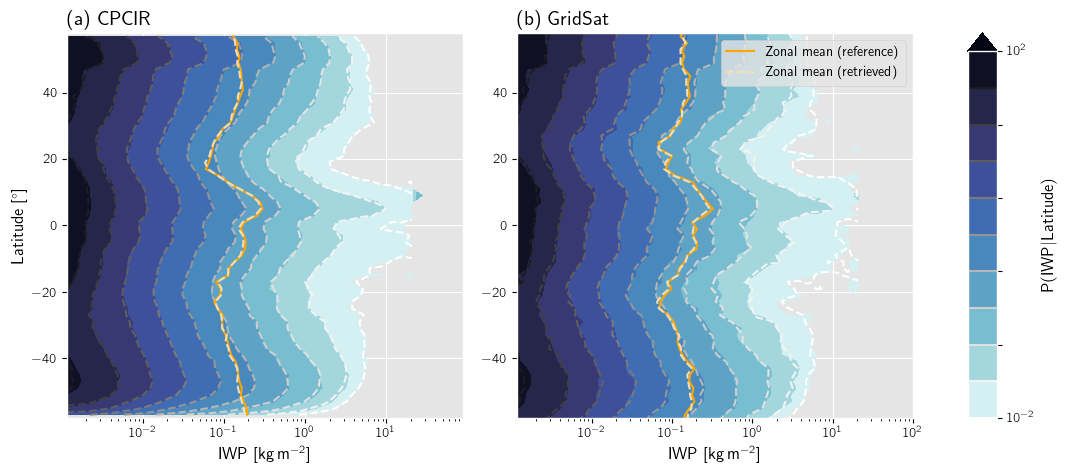

In [20]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm, Normalize
from matplotlib.cm import get_cmap, ScalarMappable

fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 3, width_ratios=[1.0, 1.0, 0.075])

lats = 0.5 * (lat_bins[1:] + lat_bins[:-1])
iwps = 0.5 * (iwp_bins[1:] + iwp_bins[:-1])
norm = LogNorm(1e-2, 1e2)
levels = np.logspace(-2, 2, 11)

m = ScalarMappable(norm=norm, cmap="Greys")
cmap = get_cmap("Greys").copy()
cmap.set_over(m.to_rgba(1e-2))

ax = fig.add_subplot(gs[0, 0])
ax.contourf(iwps, lats, y_cpc_true, norm=norm, levels=levels, extend="max")
ax.contour(iwps, lats, y_cpc_ret, norm=norm, levels=levels, linestyles="--", cmap="Greys")
ax.plot(mean_true_cpc, lats, c="orange")
ax.plot(mean_ret_cpc, lats, c="wheat", ls="--")
ax.set_xlabel("IWP [$\si{\kilo \gram \per \meter \squared}$]")
ax.set_ylabel("Latitude [$\si{\degree}$]")
ax.set_xscale("log")
ax.set_ylim([-58, 58])
ax.set_title("(a) CPCIR", loc="left")


ax = fig.add_subplot(gs[0, 1])
m_filled = ax.contourf(iwps, lats, y_gs_true, norm=norm, levels=levels, extend="max")
m_cts = ax.contour(iwps, lats, y_gs_ret, norm=norm, levels=levels, linestyles="--", cmap="Greys")
ax.plot(mean_true_gs, lats, c="orange", label="Zonal mean (reference)")
ax.plot(mean_ret_gs, lats, c="wheat", ls="--", label="Zonal mean (retrieved)")
ax.set_xlabel("IWP [$\si{\kilo \gram \per \meter \squared}$]")
ax.set_xscale("log")
ax.set_ylim([-58, 58])
ax.set_xlim([0, iwp_max])
ax.set_title("(b) GridSat", loc="left")
ax.legend()

ax = fig.add_subplot(gs[0, 2])
plt.colorbar(m_filled, cax=ax)
plt.colorbar(m_cts, label=r"$\text{P}(\text{IWP} | \text{Latitude})$", cax=ax)
fig.savefig("../figures/zonal_dist_tiwp.png", dpi=200, bbox_inches="tight")

## Retrieval accuracy of IWC

### Scatter plots

In [56]:
from scipy.stats import binned_statistic
bins = np.logspace(-3, 1, 201)
y_cpc = np.histogram2d(
    results_cpcir.tiwc_true.data.ravel(),
    results_cpcir.tiwc_mean.data.ravel(),
    bins=bins,
    density=True
)[0]
y_cpc /= np.trapz(np.diff(bins) * y_cpc, axis=-1)[..., None]

cond_mean_cpc = binned_statistic(
    results_cpcir.tiwc_true.data.ravel(),
    results_cpcir.tiwc_mean.data.ravel(),
    lambda x: x.mean() if x.size > 1e3 else np.nan,
    bins=bins
)[0]
corr_cpc = np.corrcoef(
    results_cpcir.tiwc_true.data.ravel(),
    results_cpcir.tiwc_mean.data.ravel()
)[0, 1]
bias_cpc = (
    np.mean(results_cpcir.tiwc_mean.data.ravel() - results_cpcir.tiwc_true.data.ravel()) / 
    np.mean(results_cpcir.tiwc_mean.data.ravel())
)

y_gs = np.histogram2d(
    results_gridsat.tiwc_true.data.ravel(),
    results_gridsat.tiwc_mean.data.ravel(),
    bins=bins, density=True)[0]
y_gs /= np.trapz(np.diff(bins) * y_gs, axis=-1)[..., None]

cond_mean_gs = binned_statistic(
    results_gridsat.tiwc_true.data.ravel(),
    results_gridsat.tiwc_mean.data.ravel(),
    lambda x: x.mean() if x.size > 1e3 else np.nan,
    bins=bins
)[0]
corr_gs = np.corrcoef(
    results_gridsat.tiwc_true.data.ravel(),
    results_gridsat.tiwc_mean.data.ravel()
)[0, 1]
bias_gs = (
    np.mean(results_gridsat.tiwc_mean.data.ravel() - results_gridsat.tiwc_true.data.ravel()) /
    np.mean(results_gridsat.tiwc_mean.data.ravel())
)

/tmp/ipykernel_858012/941036265.py:9: RuntimeWarning: invalid value encountered in divide
  y_cpc /= np.trapz(np.diff(bins) * y_cpc, axis=-1)[..., None]
/tmp/ipykernel_858012/941036265.py:30: RuntimeWarning: invalid value encountered in divide
  y_gs /= np.trapz(np.diff(bins) * y_gs, axis=-1)[..., None]


/tmp/ipykernel_858012/1087182079.py:16: UserWarning: Log scale: values of z <= 0 have been masked
  m = ax.contourf(x, x, y_cpc.T, norm=norm, levels=levels, extend="both")
/tmp/ipykernel_858012/1087182079.py:33: UserWarning: Log scale: values of z <= 0 have been masked
  m = ax.contourf(x, x, y_gs.T, norm=norm, levels=levels, extend="both")


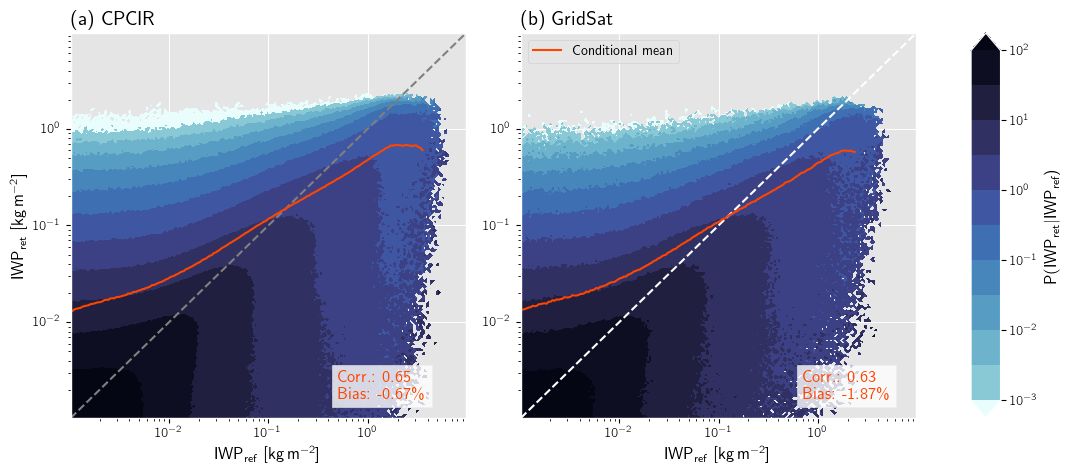

In [61]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm

fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 3, width_ratios=[1.0, 1.0, 0.075])

norm = LogNorm(1e-4, 1e2)
levels = np.logspace(-3, 2, 11)

txtcol = "orangered"
diagcol = "orangered"

ax = fig.add_subplot(gs[0, 0])
ax.set_title("(a) CPCIR", loc="left")
x = 0.5 * (bins[1:] + bins[:-1])
m = ax.contourf(x, x, y_cpc.T, norm=norm, levels=levels, extend="both")
ax.plot(x, x, ls="--", c="grey")
ax.plot(x, cond_mean_cpc, c=diagcol, label="Conditional mean")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$\text{IWP}_\text{ret}$ $[\si{\kilo \gram \per \meter \squared}$]")
ax.set_xlabel(r"$\text{IWP}_\text{ref}$ $[\si{\kilo \gram \per \meter \squared}$]")
props = dict(facecolor='white', alpha=0.8)
ax.text(
    5e-1, 1.5e-3, f"Corr.: {corr_cpc:0.2f} \n Bias: {100 * bias_cpc:0.2f}\%",
    fontsize=12, color=txtcol, ha="left", va="bottom", bbox=props
)


ax = fig.add_subplot(gs[0, 1])
ax.set_title("(b) GridSat", loc="left")
x = 0.5 * (bins[1:] + bins[:-1])
m = ax.contourf(x, x, y_gs.T, norm=norm, levels=levels, extend="both")
ax.plot(x, x, ls="--", c="white")
ax.plot(x, cond_mean_gs, c=diagcol, label="Conditional mean")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\text{IWP}_\text{ref}$ $[\si{\kilo \gram \per \meter \squared}$]")
props = dict(facecolor='white', alpha=0.8)
ax.text(7e-1, 1.5e-3, f"Corr.: {corr_gs:0.2f} \n Bias: {100 * bias_gs:0.2f}\%",
        fontsize=12, color=txtcol, ha="left", va="bottom", bbox=props)
ax.legend()

ax = fig.add_subplot(gs[0, 2])
plt.colorbar(m, label=r"$\text{P}(\text{IWP}_\text{ret} | \text{IWP}_\text{ref}$)", cax=ax)
fig.savefig("../figures/scatter_plot_tiwc.png", dpi=200, bbox_inches="tight")

## CPCIR statistics

In [63]:
from scipy.stats import binned_statistic
bins_tiwp = np.logspace(-3, 2, 201)
y_tiwp = np.histogram2d(
    results_cpcir.tiwp_true.data.ravel(),
    results_cpcir.tiwp_mean.data.ravel(),
    bins=bins_tiwp,
    density=True
)[0]
y_tiwp /= np.trapz(np.diff(bins) * y_tiwp, axis=-1)[..., None]

cond_mean_tiwp = binned_statistic(
    results_cpcir.tiwp_true.data.ravel(),
    results_cpcir.tiwp_mean.data.ravel(),
    lambda x: x.mean() if x.size > 1e3 else np.nan,
    bins=bins_tiwp
)[0]
corr_tiwp = np.corrcoef(
    results_cpcir.tiwp_true.data.ravel(),
    results_cpcir.tiwp_mean.data.ravel()
)[0, 1]
bias_tiwp = (
    np.mean(results_cpcir.tiwp_mean.data.ravel() - results_cpcir.tiwp_true.data.ravel()) / 
    np.mean(results_cpcir.tiwp_mean.data.ravel())
)

bins_tiwc = np.logspace(-4, 1, 201)
y_tiwc = np.histogram2d(
    results_cpcir.tiwc_true.data.ravel(),
    results_cpcir.tiwc_mean.data.ravel(),
    bins=bins_tiwc,
    density=True
)[0]
y_tiwc /= np.trapz(np.diff(bins_tiwc) * y_tiwc, axis=-1)[..., None]

cond_mean_tiwc = binned_statistic(
    results_cpcir.tiwc_true.data.ravel(),
    results_cpcir.tiwc_mean.data.ravel(),
    lambda x: x.mean() if x.size > 1e3 else np.nan,
    bins=bins_tiwc
)[0]
corr_tiwc = np.corrcoef(
    results_cpcir.tiwc_true.data.ravel(),
    results_cpcir.tiwc_mean.data.ravel()
)[0, 1]
bias_tiwc = (
    np.mean(results_cpcir.tiwc_mean.data.ravel() - results_cpcir.tiwc_true.data.ravel()) / 
    np.mean(results_cpcir.tiwc_mean.data.ravel())
)

/tmp/ipykernel_858012/983478178.py:9: RuntimeWarning: invalid value encountered in divide
  y_tiwp /= np.trapz(np.diff(bins) * y_tiwp, axis=-1)[..., None]
/tmp/ipykernel_858012/983478178.py:33: RuntimeWarning: invalid value encountered in divide
  y_tiwc /= np.trapz(np.diff(bins_tiwc) * y_tiwc, axis=-1)[..., None]


/tmp/ipykernel_858012/2943497696.py:16: UserWarning: Log scale: values of z <= 0 have been masked
  m = ax.contourf(x, x, y_tiwp.T, norm=norm, levels=levels, extend="both")
/tmp/ipykernel_858012/2943497696.py:33: UserWarning: Log scale: values of z <= 0 have been masked
  m = ax.contourf(x, x, y_tiwc.T, norm=norm, levels=levels, extend="both")


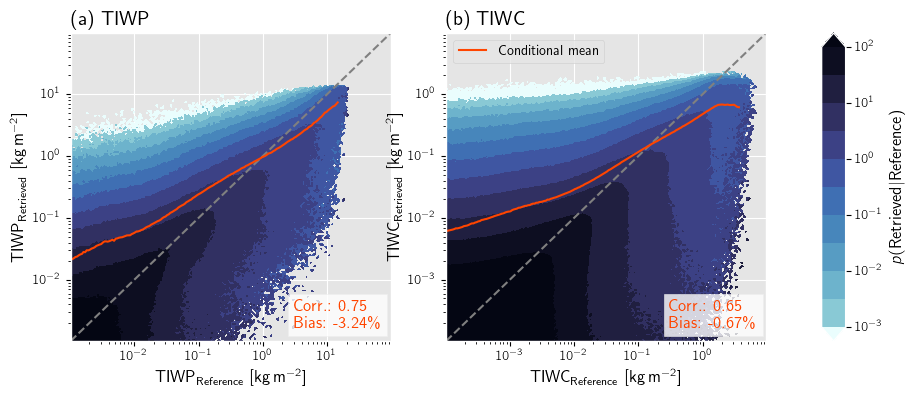

In [64]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm

fig = plt.figure(figsize=(10, 4))
gs = GridSpec(1, 3, width_ratios=[1.0, 1.0, 0.075], wspace=0.25)

norm = LogNorm(1e-4, 1e2)
levels = np.logspace(-3, 2, 11)

txtcol = "orangered"
diagcol = "orangered"

ax = fig.add_subplot(gs[0, 0])
ax.set_title("(a) TIWP", loc="left")
x = 0.5 * (bins_tiwp[1:] + bins_tiwp[:-1])
m = ax.contourf(x, x, y_tiwp.T, norm=norm, levels=levels, extend="both")
ax.plot(x, x, ls="--", c="grey")
ax.plot(x, cond_mean_tiwp, c=diagcol, label="Conditional mean")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$\text{TIWP}_\text{Retrieved}$ $[\si{\kilo \gram \per \meter \squared}$]")
ax.set_xlabel(r"$\text{TIWP}_\text{Reference}$ $[\si{\kilo \gram \per \meter \squared}$]")
props = dict(facecolor='white', alpha=0.8)
ax.text(
    3e0, 1.5e-3, f"Corr.: {corr_tiwp:0.2f} \n Bias: {100 * bias_tiwp:0.2f}\%",
    fontsize=12, color=txtcol, ha="left", va="bottom", fontweight="bold", bbox=props
)


ax = fig.add_subplot(gs[0, 1])
ax.set_title("(b) TIWC", loc="left")
x = 0.5 * (bins_tiwc[1:] + bins_tiwc[:-1])
m = ax.contourf(x, x, y_tiwc.T, norm=norm, levels=levels, extend="both")
ax.plot(x, x, ls="--", c="grey")
ax.plot(x, cond_mean_tiwc, c=diagcol, label="Conditional mean")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\text{TIWC}_\text{Reference}$ $[\si{\kilo \gram \per \meter \squared}$]")
ax.set_ylabel(r"$\text{TIWC}_\text{Retrieved}$ $[\si{\kilo \gram \per \meter \squared}$]")
props = dict(facecolor='white', alpha=0.8)
ax.text(3e-1, 1.5e-4, f"Corr.: {corr_tiwc:0.2f} \n Bias: {100 * bias_tiwc:0.2f}\%",
        fontsize=12, color=txtcol, ha="left", va="bottom", fontweight="bold", bbox=props)
ax.legend()

ax = fig.add_subplot(gs[0, 2])
plt.colorbar(m, label=r"$p(\text{Retrieved} | \text{Reference}$)", cax=ax)
fig.savefig("../figures/scatter_plot_cpcir.pdf", dpi=200, bbox_inches="tight")

### Altitude distribution of IWC

In [25]:
iwc_bins = np.logspace(-3, 1, 41)
alt_bins = np.linspace(0, 20, 21) * 1e3

alts = np.broadcast_to(results_cpcir.levels.data[None], results_cpcir.tiwc_true.data.shape)

y_cpc_true = np.histogram2d(
    alts.ravel(),
    results_cpcir.tiwc_true.data.ravel(),
    bins=(alt_bins, iwc_bins),
    density=True
)[0]
y_cpc_true /= np.trapz(np.diff(iwc_bins)[None] * y_cpc_true, axis=0)[None]
y_cpc_ret = np.histogram2d(
    alts.ravel(),
    results_cpcir.tiwc_sample.data.ravel(),
    bins=(alt_bins, iwc_bins),
    density=True
)[0]
y_cpc_ret /= np.trapz(np.diff(iwc_bins)[None] * y_cpc_ret, axis=0)[None]
mean_true_cpc = binned_statistic(alts.ravel(), results_cpcir.tiwc_true.data.ravel(), bins=alt_bins)[0]
mean_ret_cpc = binned_statistic(alts.ravel(), results_cpcir.tiwc_mean.data.ravel(), bins=alt_bins)[0]

alts = np.broadcast_to(results_gridsat.levels.data[None], results_gridsat.tiwc_true.data.shape)
y_gs_true = np.histogram2d(
    alts.ravel(),
    results_gridsat.tiwc_true.data.ravel(),
    bins=(alt_bins, iwc_bins),
    density=True
)[0]
y_gs_true /= np.trapz(np.diff(iwc_bins)[None] * y_gs_true, axis=0)[None]
y_gs_ret = np.histogram2d(
    alts.ravel(),
    results_gridsat.tiwc_sample.data.ravel(),
    bins=(alt_bins, iwc_bins),
    density=True
)[0]
y_gs_ret /= np.trapz(np.diff(iwc_bins)[None] * y_gs_ret, axis=0)[None]
mean_true_gs = binned_statistic(alts.ravel(), results_gridsat.tiwc_true.data.ravel(), bins=alt_bins)[0]
mean_ret_gs = binned_statistic(alts.ravel(), results_gridsat.tiwc_mean.data.ravel(), bins=alt_bins)[0]

/tmp/ipykernel_858012/1080494832.py:19: RuntimeWarning: invalid value encountered in divide
  y_cpc_ret /= np.trapz(np.diff(iwc_bins)[None] * y_cpc_ret, axis=0)[None]
/tmp/ipykernel_858012/1080494832.py:30: RuntimeWarning: invalid value encountered in divide
  y_gs_true /= np.trapz(np.diff(iwc_bins)[None] * y_gs_true, axis=0)[None]
/tmp/ipykernel_858012/1080494832.py:37: RuntimeWarning: invalid value encountered in divide
  y_gs_ret /= np.trapz(np.diff(iwc_bins)[None] * y_gs_ret, axis=0)[None]


/tmp/ipykernel_858012/3225724543.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("Greys").copy()
/tmp/ipykernel_858012/3225724543.py:17: UserWarning: Log scale: values of z <= 0 have been masked
  ax.contourf(iwcs, alts, y_cpc_true, norm=norm, levels=levels, extend="max")
/tmp/ipykernel_858012/3225724543.py:18: UserWarning: Log scale: values of z <= 0 have been masked
  ax.contour(iwcs, alts, y_cpc_ret, norm=norm, levels=levels, linestyles="--", cmap="Greys")
/tmp/ipykernel_858012/3225724543.py:30: UserWarning: Log scale: values of z <= 0 have been masked
  m_filled = ax.contourf(iwcs, alts, y_gs_true, norm=norm, levels=levels, extend="max")
/tmp/ipykernel_858012/3225724543.py:31: UserWarning: Log scale: values of z <= 0 have been masked
  m_cts = ax.contour(iwcs, alts, y_gs_ret, norm=norm, leve

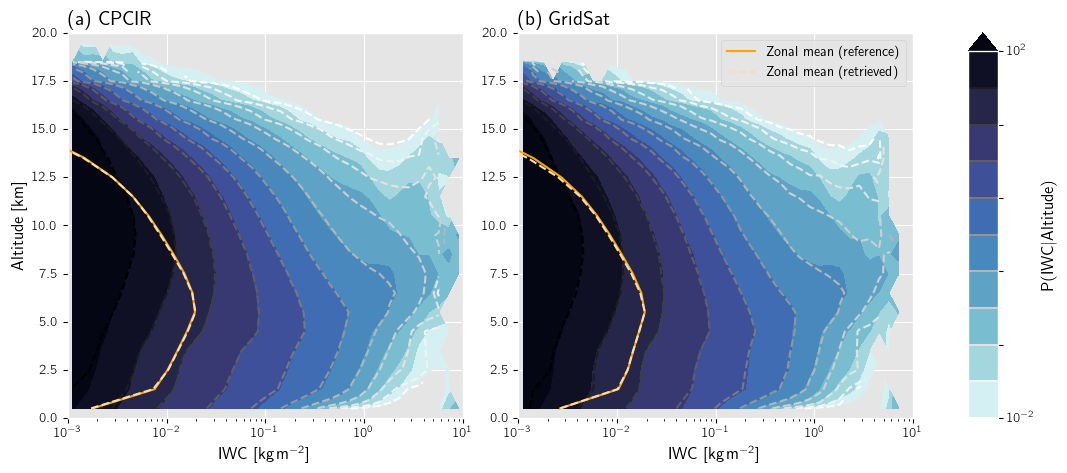

In [26]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm, Normalize
from matplotlib.cm import get_cmap, ScalarMappable

fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 3, width_ratios=[1.0, 1.0, 0.075])

alts = 0.5 * (alt_bins[1:] + alt_bins[:-1]) / 1e3
iwcs = 0.5 * (iwc_bins[1:] + iwc_bins[:-1])
norm = LogNorm(1e-2, 1e2)
levels = np.logspace(-2, 2, 11)

m = ScalarMappable(norm=norm, cmap="Greys")
cmap = get_cmap("Greys").copy()

ax = fig.add_subplot(gs[0, 0])
ax.contourf(iwcs, alts, y_cpc_true, norm=norm, levels=levels, extend="max")
ax.contour(iwcs, alts, y_cpc_ret, norm=norm, levels=levels, linestyles="--", cmap="Greys")
ax.plot(mean_true_cpc, alts, c="orange")
ax.plot(mean_ret_cpc, alts, c="wheat", ls="--")
ax.set_xlabel("IWC [$\si{\kilo \gram \per \meter \squared}$]")
ax.set_ylabel("Altitude [$\si{\kilo \meter}$]")
ax.set_xscale("log")
ax.set_ylim([0, 20])
ax.set_xlim([1e-3, 1e1])
ax.set_title("(a) CPCIR", loc="left")


ax = fig.add_subplot(gs[0, 1])
m_filled = ax.contourf(iwcs, alts, y_gs_true, norm=norm, levels=levels, extend="max")
m_cts = ax.contour(iwcs, alts, y_gs_ret, norm=norm, levels=levels, linestyles="--", cmap="Greys")
ax.plot(mean_true_gs, alts, c="orange", label="Zonal mean (reference)")
ax.plot(mean_ret_gs, alts, c="wheat", ls="--", label="Zonal mean (retrieved)")
ax.set_xlabel("IWC [$\si{\kilo \gram \per \meter \squared}$]")
ax.set_xscale("log")
ax.set_ylim([0, 20])
ax.set_xlim([1e-3, 1e1])
ax.set_title("(b) GridSat", loc="left")
ax.legend()

ax = fig.add_subplot(gs[0, 2])
plt.colorbar(m_filled, cax=ax)
plt.colorbar(m_cts, label=r"$\text{P}(\text{IWC} | \text{Altitude})$", cax=ax)

fig.savefig("../figures/altitude_dist_tiwc.png", dpi=200, bbox_inches="tight")

# Cloud detection

In [27]:
from sklearn.metrics import precision_recall_curve

cp = results_cpcir.cloud_prob.data.ravel()
cp_true = results_cpcir.cloud_prob_true.data.ravel()
prec_cp_cpcir, rec_cp_cpcir, thresh = precision_recall_curve(
    cp_true.astype("bool"),
    cp
)
d = np.sqrt((1.0 - prec_cp_cpcir) ** 2 + (1.0 - rec_cp_cpcir) ** 2)
t_cp_cpcir = thresh[np.argmin(d)]
prec_cp_cpcir_opt = prec_cp_cpcir[np.argmin(d)]
rec_cp_cpcir_opt = rec_cp_cpcir[np.argmin(d)]

cp = results_gridsat.cloud_prob.data.ravel()
cp_true = results_gridsat.cloud_prob_true.data.ravel()
prec_cp_gridsat, rec_cp_gridsat, thresh = precision_recall_curve(cp_true.astype("bool"), cp)
d = np.sqrt((1.0 - prec_cp_gridsat) ** 2 + (1.0 - rec_cp_gridsat) ** 2)
t_cp_gridsat = thresh[np.argmin(d)]
prec_cp_gridsat_opt = prec_cp_gridsat[np.argmin(d)]
rec_cp_gridsat_opt = rec_cp_gridsat[np.argmin(d)]

In [28]:
cm = results_cpcir.cloud_class_prob.data[..., 0].ravel()
cm_true = results_cpcir.cloud_class_true.data.ravel() == 0
prec_cm_cpcir, rec_cm_cpcir, thresh = precision_recall_curve(
    ~cm_true,
    1.0 - cm
)
d = np.sqrt((1.0 - prec_cm_cpcir) ** 2 + (1.0 - rec_cm_cpcir) ** 2)
t_cm_cpcir = thresh[np.argmin(d)]
prec_cm_cpcir_opt = prec_cm_cpcir[np.argmin(d)]
rec_cm_cpcir_opt = rec_cm_cpcir[np.argmin(d)]

cm = results_gridsat.cloud_class_prob.data[..., 0].ravel()
cm_true = results_gridsat.cloud_class_true.data.ravel() == 0
prec_cm_gridsat, rec_cm_gridsat, thresh = precision_recall_curve(
    ~cm_true,
    1.0 - cm
)
d = np.sqrt((1.0 - prec_cm_gridsat) ** 2 + (1.0 - rec_cm_gridsat) ** 2)
t_cm_gridsat = thresh[np.argmin(d)]
prec_cm_gridsat_opt = prec_cm_gridsat[np.argmin(d)]
rec_cm_gridsat_opt = rec_cm_gridsat[np.argmin(d)]

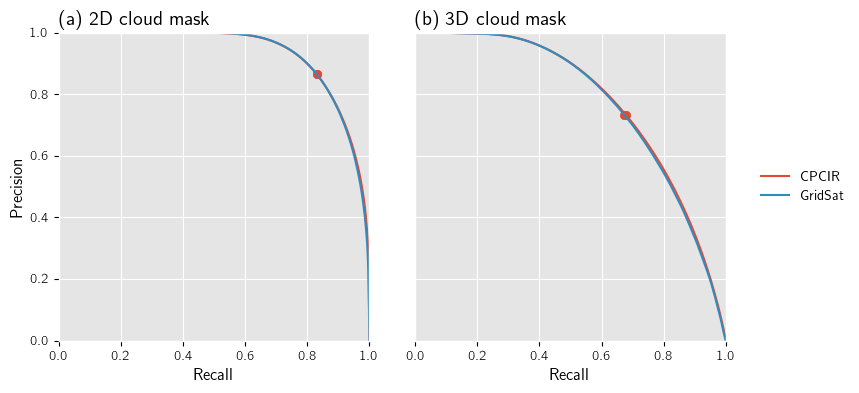

In [35]:
from matplotlib.gridspec import GridSpec

f = plt.figure(figsize=(10, 4))
gs = GridSpec(1, 3, width_ratios=[1.0, 1.0, 0.2])

ax = f.add_subplot(gs[0, 0])
ax.plot(prec_cp_cpcir, rec_cp_cpcir, label="CPCIR", c="C0")
ax.scatter([prec_cp_cpcir_opt], [rec_cp_cpcir_opt], c="C0")
ax.plot(prec_cp_gridsat, rec_cp_gridsat, label="CPCIR", c="C1")
ax.scatter([prec_cp_gridsat_opt], [rec_cp_gridsat_opt], c="C0")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
ax.set_title("(a) 2D cloud mask", loc="left")

ax = f.add_subplot(gs[0, 1])
handles = []
handles += ax.plot(prec_cm_cpcir, rec_cm_cpcir, label="CPCIR", c="C0")
ax.scatter([prec_cm_cpcir_opt], [rec_cm_cpcir_opt], c="C0")
handles += ax.plot(prec_cm_gridsat, rec_cm_gridsat, label="GridSat", c="C1")
ax.scatter([prec_cm_gridsat_opt], [rec_cm_gridsat_opt], c="C0")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_yticklabels([])
ax.set_xlabel("Recall")
ax.set_title("(b) 3D cloud mask", loc="left")

for l in ax.yaxis.get_ticklines():
    l.set_visible(False)
    
ax = f.add_subplot(gs[0, 2])
ax.legend(handles=handles, loc="center", facecolor="none", edgecolor="none")
ax.set_axis_off()

f.savefig("../figures/cloud_detection_prec_rec.pdf")

## Confusion matrix

In [36]:
from sklearn.metrics import confusion_matrix

In [37]:
cc = results_cpcir.cloud_class.data.ravel()
cc_t = results_cpcir.cloud_class_true.data.ravel()
valid = cc_t <= 8
cc = cc[valid]
cc_t = cc_t[valid]
cm_cpcir = confusion_matrix(cc_t, cc, normalize="true")

cc = results_gridsat.cloud_class.data.ravel()
cc_t = results_gridsat.cloud_class_true.data.ravel()
valid = cc_t <= 8
cc = cc[valid]
cc_t = cc_t[valid]
cm_gridsat = confusion_matrix(cc_t, cc, normalize="true")

In [38]:
cloud_types = [
    "No cloud",
    "Ci",
    "As",
    "Ac",
    "St",
    "Sc",
    "Cu",
    "Ns",
    "Deep convection"
]

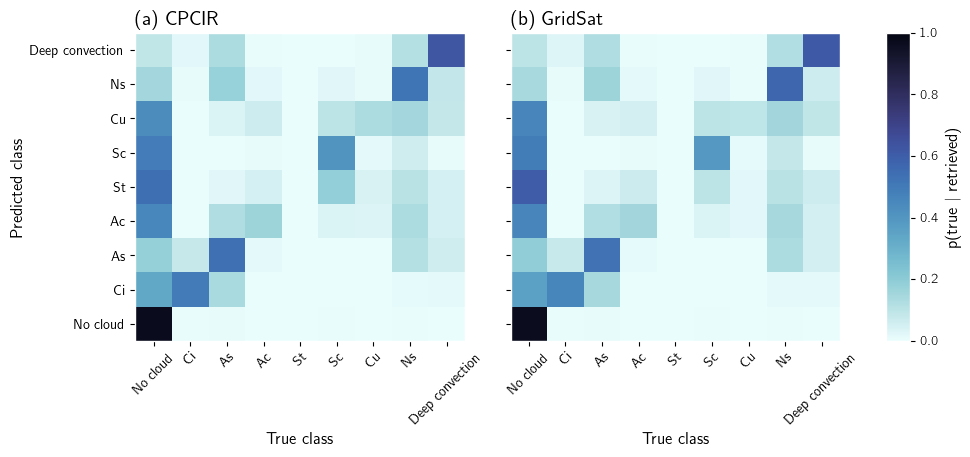

In [39]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize

fig = plt.figure(figsize=(10, 4))
gs = GridSpec(1, 3, width_ratios=[1.0, 1.0, 0.075])
norm = Normalize(0, 1)

ax = fig.add_subplot(gs[0, 0])
ax.pcolormesh(cm_cpcir, norm=norm, rasterized=True)
ax.set_xticks(np.arange(9) + 0.5)
ax.set_xticklabels(cloud_types)
ax.set_yticks(np.arange(9) + 0.5)
ax.set_yticklabels(cloud_types)
for l in ax.xaxis.get_ticklabels():
    l.set_rotation(45)
ax.set_title("(a) CPCIR", loc="left")
ax.set_xlabel("True class")
ax.set_ylabel("Predicted class")

ax = fig.add_subplot(gs[0, 1])
m = ax.pcolormesh(cm_gridsat, norm=norm, rasterized=True)
ax.set_xticks(np.arange(9) + 0.5)
ax.set_xticklabels(cloud_types)
ax.set_yticks(np.arange(9) + 0.5)
ax.set_yticklabels(cloud_types)
for l in ax.xaxis.get_ticklabels():
    l.set_rotation(45)
for l in ax.yaxis.get_ticklabels():
    l.set_visible(False)
ax.set_title("(b) GridSat", loc="left")
ax.set_xlabel("True class")

ax = fig.add_subplot(gs[0, 2])
plt.colorbar(m, cax=ax, label="p(true $|$ retrieved)")

fig.savefig("../figures/confusion_matrix_cloud_mask.pdf", bbox_inches="tight")

In [40]:
def transform_cloud_types(cloud_types):
    cloud_types_new = np.zeros_like(cloud_types)
    strat = (cloud_types > 0) * (cloud_types < 6)
    cloud_types_new[strat] = 1
    conv = (cloud_types >= 6)
    cloud_types_new[conv] = 2
    return cloud_types_new

In [41]:
cc = results_cpcir.cloud_class.data.ravel()
cc_t = results_cpcir.cloud_class_true.data.ravel()
valid = cc_t <= 8
cc = cc[valid]
cc_t = cc_t[valid]
cm_cpcir = confusion_matrix(
    transform_cloud_types(cc_t),
    transform_cloud_types(cc),
    normalize="pred"
)

cc = results_gridsat.cloud_class.data.ravel()
cc_t = results_gridsat.cloud_class_true.data.ravel()
valid = cc_t <= 8
cc = cc[valid]
cc_t = cc_t[valid]
cm_gridsat = confusion_matrix(
    transform_cloud_types(cc_t),
    transform_cloud_types(cc),
    normalize="pred"
)

## Column classification

In [44]:
tbs = results_cpcir.tbs.data
tiwp = results_cpcir.tiwp_mean.data
cc = results_cpcir.column_class.data

cc_bins = np.arange(4) - 0.5
iwp_bins = np.logspace(-5, 2, 101)
tb_bins = np.linspace(180, 300, 101)

y_tiwp = np.histogram2d(cc, tiwp, (cc_bins, iwp_bins))[0]
y_tiwp /= np.sum(y_tiwp, 0, keepdims=True)
y_tbs = np.histogram2d(cc, tbs, (cc_bins, tb_bins))[0]
y_tbs /= np.sum(y_tbs, 0, keepdims=True)

/tmp/ipykernel_858012/976888124.py:10: RuntimeWarning: invalid value encountered in divide
  y_tiwp /= np.sum(y_tiwp, 0, keepdims=True)
/tmp/ipykernel_858012/976888124.py:12: RuntimeWarning: invalid value encountered in divide
  y_tbs /= np.sum(y_tbs, 0, keepdims=True)


(300.0, 180.0)

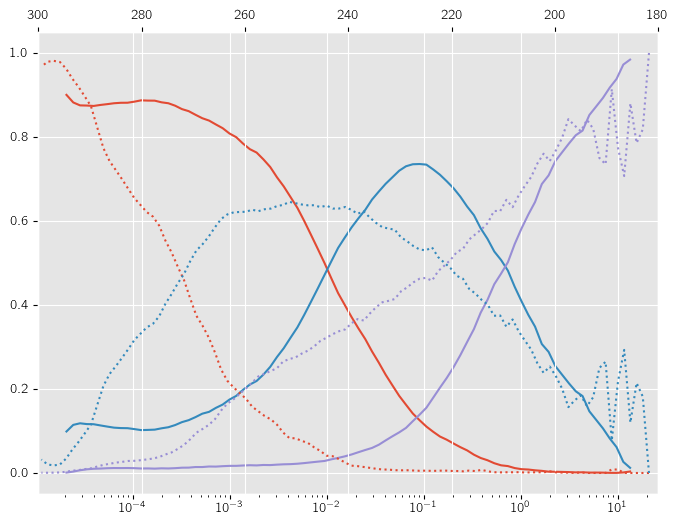

In [45]:
f, ax = plt.subplots(1, 1, figsize=(8, 6))

x = 0.5 * (iwp_bins[1:] + iwp_bins[:-1])
ax.plot(x, y_tiwp[0])
ax.plot(x, y_tiwp[1])
ax.plot(x, y_tiwp[2])
ax.set_xscale("log")

ax = ax.twiny()
x = 0.5 * (tb_bins[1:] + tb_bins[:-1])
ax.plot(x, y_tbs[0], ls=":")
ax.plot(x, y_tbs[1], ls=":")
ax.plot(x, y_tbs[2], ls=":")
ax.set_xlim(tb_bins[-1], tb_bins[0])



In [47]:
from sklearn.metrics import precision_recall_curve
tbs = results_cpcir.tbs.data
valid = np.isfinite(tbs)
tbs = tbs[valid]
tiwp = results_cpcir.tiwp_mean.data[valid]
cc = results_cpcir.column_class.data[valid]

prec_cloud_tbs_cpcir, rec_cloud_tbs_cpcir, _ = precision_recall_curve(cc > 0, -tbs)
prec_cloud_tiwp_cpcir, rec_cloud_tiwp_cpcir, _ = precision_recall_curve(cc > 0, tiwp)

prec_conv_tbs_cpcir, rec_conv_tbs_cpcir, _ = precision_recall_curve(cc > 1, -tbs)
prec_conv_tiwp_cpcir, rec_conv_tiwp_cpcir, _ = precision_recall_curve(cc > 1, tiwp)


In [48]:
tbs = results_gridsat.tbs.data
valid = np.isfinite(tbs)
tbs = tbs[valid]
tiwp = results_gridsat.tiwp_mean.data[valid]
cc = results_gridsat.column_class.data[valid]

prec_cloud_tbs_gridsat, rec_cloud_tbs_gridsat, _ = precision_recall_curve(cc > 0, -tbs)
prec_cloud_tiwp_gridsat, rec_cloud_tiwp_gridsat, _ = precision_recall_curve(cc > 0, tiwp)

prec_conv_tbs_gridsat, rec_conv_tbs_gridsat, _ = precision_recall_curve(cc > 1, -tbs)
prec_conv_tiwp_gridsat, rec_conv_tiwp_gridsat, _ = precision_recall_curve(cc > 1, tiwp)

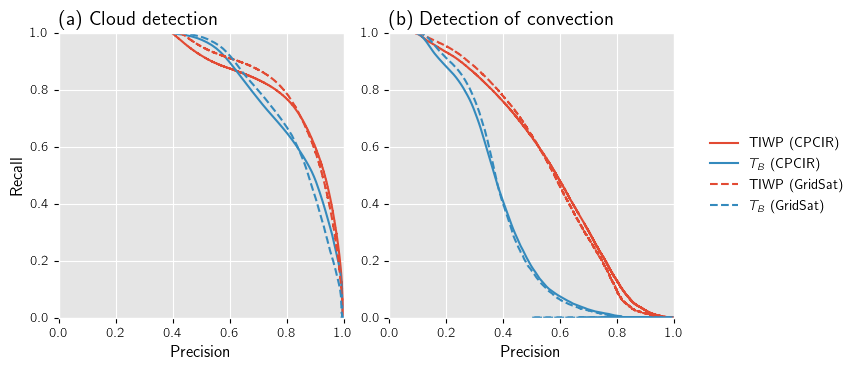

In [55]:
gs = GridSpec(1, 3, width_ratios=[1.0, 1.0, 0.4])
f = plt.figure(figsize=(10, 4))

ax = f.add_subplot(gs[0, 0])
handles = []
handles += ax.plot(prec_cloud_tiwp_cpcir, rec_cloud_tiwp_cpcir, label="TIWP (CPCIR)", c="C0")
handles += ax.plot(prec_cloud_tbs_cpcir, rec_cloud_tbs_cpcir, label="$T_B$ (CPCIR)", c="C1")
handles += ax.plot(prec_cloud_tiwp_gridsat, rec_cloud_tiwp_gridsat, label="TIWP (GridSat)", c="C0", ls="--")
handles += ax.plot(prec_cloud_tbs_gridsat, rec_cloud_tbs_gridsat, label="$T_B$ (GridSat)", c="C1", ls="--")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel("Precision")
ax.set_ylabel("Recall")
ax.set_title("(a) Cloud detection", loc="left")
ax.set_aspect(1.0)

ax = f.add_subplot(gs[0, 1])
ax.plot(prec_conv_tiwp_cpcir, rec_conv_tiwp_cpcir, label="TIWP (CPCIR)", c="C0")
ax.plot(prec_conv_tbs_cpcir, rec_conv_tbs_cpcir, label="$T_B$ (CPCIR)", c="C1")
ax.plot(prec_conv_tiwp_gridsat, rec_conv_tiwp_gridsat, label="TIWP (GridSat)", c="C0", ls="--")
ax.plot(prec_conv_tbs_gridsat, rec_conv_tbs_gridsat, label="$T_B$ (GridSat)", c="C1", ls="--")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel("Precision")
ax.set_title("(b) Detection of convection", loc="left")
ax.set_aspect(1.0)

ax = f.add_subplot(gs[0, -1])
ax.set_axis_off()
ax.legend(handles=handles, loc="center", edgecolor="none", facecolor="none")

f.savefig("../figures/cloud_detection.pdf", bbox_inches="tight")
f.savefig("../figures/cloud_detection.svg", bbox_inches="tight")